In [1]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
NADH     = Phasor([0.75,0.25],[0.4,4])         #sim object
EGFP     = Phasor([0.497,0.503],[2.43,3.07])   #EGFP object
mCherry  = Phasor([0.83,0.17],[1.43,2.38]) #mCherry object
sim_list = [NADH,EGFP,mCherry]
sim_name = ['NADH','EGFP','mCherry']
for i in range(3):
    sim_list[i].name = sim_name[i] #add name attributes to objects

### Error bars

The data is rescaled such that the first data point $y_0$ is 1, i.e. $\tilde{y} = y/y_0$\
Error in rescaled data $\tilde{y}$:
$$\Delta \tilde{y} = \tilde{y} \cdot \sqrt{\left(\frac{\Delta y}{y}\right)^2+\left(\frac{\Delta y}{y_0}\right)^2}$$ 
where $\Delta y = \sqrt{y}$ as it is Poissonian noise.\
Hence $$\Delta \tilde{y} = \frac{y}{y_0}\sqrt{\frac{1}{y}+\frac{1}{y_0}}$$

In [30]:
EGFP.repeat_sim_results(method = 'leastsq')
EGFP.info_df
result = EGFP.fit_results[4]

In [31]:
def plot_fit(result):
    '''Plot data and fitted line, with normalized residuals in another plot.
       Input:
       ModelResult object from lmfit (after fitting)
       Output:
       figure and axes objects'''
    fig,ax = plt.subplots(nrows = 2, ncols =1,figsize = (6,5),gridspec_kw = {'height_ratios':[4,1]},sharex = True)
    result.plot_fit(ax=ax[0],datafmt = 'x',data_kws = {'alpha':0.7,'zorder':1})
    xdata = ax[0].lines[0].get_xdata() #xdata array for plotting residuals
    #Normalized residuals
    ax[1].set_ylabel('Normalized residuals')
    ax[1].plot(xdata,result.residual,'x')
    ax[1].axhline(0,c='k')
    ax[1].add_patch(mpl.patches.Rectangle((0,-1),xdata[-1],2,alpha = 0.3,color='g'))
    ax[1].set_yticks([-2,-1,0,1,2])
    for i in range(2):
        ax[i].set_xlim([0,xdata[-1]])
    ax[0].set_ylabel('Rescaled number of photons')
    ax[1].set_xlabel('Time/ns')
    ax[0].set_xlabel('')
    ax[0].set_yscale('log')
    for i in range(3):
        ax[0].text(10.5,np.logspace(-0.5,-0.85,4)[i],[v.name + rf' = {v.value:0.2f} $\pm$ {v.stderr:0.2f}' for v in result.params.values()][i])
    ax[0].text(10.5,np.logspace(-0.5,-0.85,4)[3],rf'reduced $\chi^2$ = {result.redchi:0.2f}')
    return fig,ax

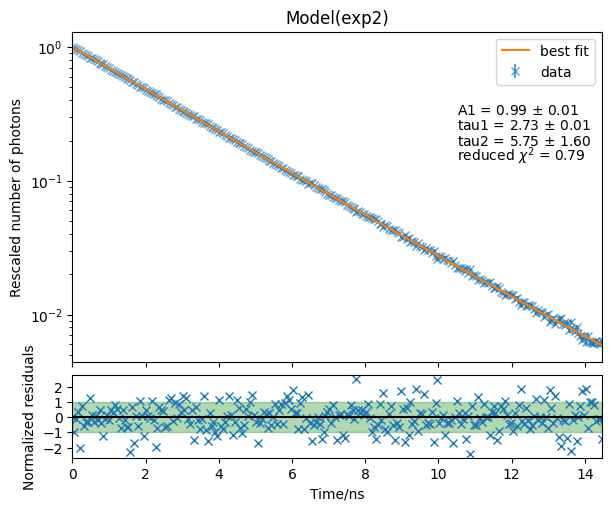

In [32]:
fig,ax = plot_fit(result)

In [ ]:
EGFP.repeat_sim_results(method = 'cobyla')

In [34]:
EGFP.info_df

,chisqr,redchi,_val,init_value,stderr,correl
0,236.480688,0.869414,"[0.493, 2.47, 3.04]","[0.497, 2.43, 3.07]","[0.211, 0.116, 0.123]","[{'tau1': '0.996', 'tau2': '0.997'}, {'A1': '0..."
1,223.053781,0.820051,"[0.507, 2.45, 3.07]","[0.497, 2.43, 3.07]","[0.49, 0.3, 0.311]","[{'tau1': '1', 'tau2': '1'}, {'A1': '1', 'tau2..."
2,275.993081,1.014680,"[0.499, 2.42, 3.08]","[0.497, 2.43, 3.07]","[nan, nan, nan]","[{'tau1': 'nan', 'tau2': 'nan'}, {'A1': 'nan',..."
3,238.132767,0.875488,"[0.497, 2.43, 3.07]","[0.497, 2.43, 3.07]","[nan, nan, nan]","[{'tau1': 'nan', 'tau2': 'nan'}, {'A1': 'nan',..."
4,224.927217,0.826938,"[0.505, 2.49, 3.04]","[0.497, 2.43, 3.07]","[0.198, 0.102, 0.115]","[{'tau1': '0.994', 'tau2': '0.996'}, {'A1': '0..."
...,...,...,...,...,...,...
95,232.746616,0.855686,"[0.499, 2.44, 3.06]","[0.497, 2.43, 3.07]","[nan, nan, nan]","[{'tau1': 'nan', 'tau2': 'nan'}, {'A1': 'nan',..."
96,254.541287,0.935814,"[0.494, 2.45, 3.05]","[0.497, 2.43, 3.07]","[nan, nan, nan]","[{'tau1': 'nan', 'tau2': 'nan'}, {'A1': 'nan',..."
97,260.102489,0.956259,"[0.5, 2.39, 3.09]","[0.497, 2.43, 3.07]","[0.0934, 0.0663, 0.0664]","[{'tau1': '0.99', 'tau2': '0.993'}, {'A1': '0...."
98,327.537741,1.204183,"[0.491, 2.53, 3]","[0.497, 2.43, 3.07]","[0.271, 0.121, 0.135]","[{'tau1': '0.992', 'tau2': '0.995'}, {'A1': '0..."


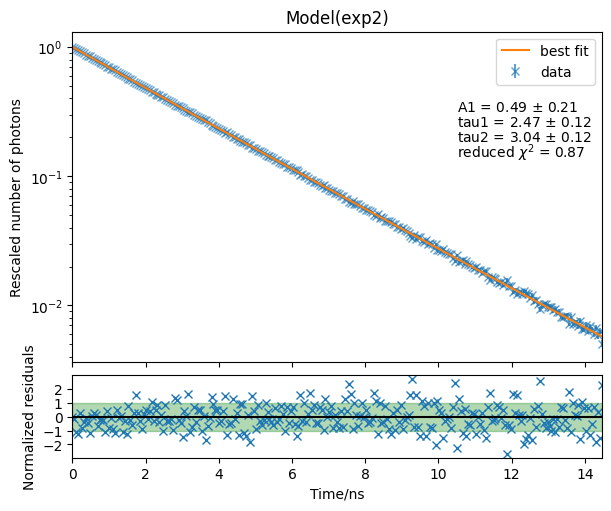

In [35]:
result = EGFP.fit_results[0]
fig2,ax2 = plot_fit(result)